# Isotropic Model Merger Rate Sampler

In [1]:
import bilby as bb
import gwpopulation as gwpop
import matplotlib.pyplot as plt
import pandas as pd
import jax
from bilby.core.prior import PriorDict, Uniform
import jax_healpy as hp
gwpop.set_backend("jax")

xp = gwpop.utils.xp

%matplotlib inline

# Load Posteriors
Need to remove BHNS events as they ruin the likelihood

In [2]:
Posteriors = list()
import pickle

# Load the pickled list of dictionaries
with open("O3a_FINAL_parameter_posteriors.pkl", "rb") as f:
    raw_event_data = pickle.load(f)

# Convert each event's dictionary into a DataFrame
for event in raw_event_data:
    # Remove the event name key — we'll store it as metadata instead
    event_name = event.pop("event", None)
    df = pd.DataFrame(event)
    df.attrs["event"] = event_name  # Store event label as metadata
    Posteriors.append(df)

with open("O3b_FINAL_parameter_posteriors.pkl", "rb") as f:
    raw_event_data = pickle.load(f)

# Convert each event's dictionary into a DataFrame
for event in raw_event_data:
    # Remove the event name key — we'll store it as metadata instead
    event_name = event.pop("event", None)
    df = pd.DataFrame(event)
    df.attrs["event"] = event_name  # Store event label as metadata
    Posteriors.append(df)


# Suppose your list of DataFrames is called `dataframes`
Posteriors_filtered = [df for df in Posteriors if len(df["mass_1"]) >= 2000]


del Posteriors_filtered[67]
del Posteriors_filtered[53]
del Posteriors_filtered[46]
del Posteriors_filtered[26]

#print(Posteriors_filtered[25]['full_event'])
#for i, df in enumerate(Posteriors_filtered):
#    event_name = df.attrs.get("event", f"unnamed_event_{i}")
#    print(f"{i}: {event_name}")

for i in range(0, len(Posteriors_filtered)):
    del Posteriors_filtered[i]["full_event"] 

print(len(Posteriors_filtered))

67


# Load Injections

In [3]:
from gwpopulation_pipe.vt_helper import load_injection_data
import h5py

def load_injection_data_with_sky(vt_file, ifar_threshold=1, snr_threshold=10):
    # Call your existing standard function to get the injections dict (VTData or dict)
    injections = load_injection_data(vt_file, ifar_threshold, snr_threshold)
    
    # Open the file again to extract sky location arrays if present
    with h5py.File(vt_file, "r") as ff:
        # Try common keys for sky position in injections or events group
        ra = None
        dec = None
        if "injections" in ff and "right_ascension" in ff["injections"]:
            ra = xp.array(ff["injections"]["right_ascension"][()])
            dec = xp.array(ff["injections"]["declination"][()])
        elif "events" in ff and "right_ascension" in ff["events"].dtype.names:
            ra = xp.array(ff["events"]["right_ascension"][()])
            dec = xp.array(ff["events"]["declination"][()])
        
        # If found, apply the same selection mask as used for injections (usually `found`)
        # This assumes you have access to the `found` mask, otherwise extract it again here:
        # For now let's assume the selection mask is the same length as injections.mass_1
        
        if ra is not None and dec is not None:
            # Match the length by slicing or by assuming same order as injections.mass_1
            n = len(injections.mass_1)
            injections.ra = ra[:n]
            injections.dec = dec[:n]
        else:
            print("Warning: RA/DEC not found in the injection file.")

    return injections

injections = load_injection_data_with_sky(
    "/data/wiay/gw-data-releases/2023/7890437/endo3_bbhpop-LIGO-T2100113-v12.hdf5",
    #"/data/wiay/gw-data-releases/2023/7890437/endo3_bbhpop-LIGO-T2100113-v12-1238166018-15843600.hdf5",
    #"/data/wiay/gw-data-releases/2023/7890437/endo3_bbhpop-LIGO-T2100113-v12-1256655642-12905976.hdf5",
    ifar_threshold=1.0,
    snr_threshold=10.0
)

15:15 bilby INFO    : Loading VT data from /data/wiay/gw-data-releases/2023/7890437/endo3_bbhpop-LIGO-T2100113-v12.hdf5.


# Define Priors
Need to find good numbers and replace with delta functions for all but sky model.

In [4]:
priors = PriorDict()
from bilby.core.prior import DeltaFunction, Exponential, Uniform, Sine, PowerLaw

# mass
priors["alpha"] = Uniform(minimum=-2, maximum=4, latex_label="$\\alpha$")
priors["beta"] = Uniform(minimum=-4, maximum=12, latex_label="$\\beta$")
priors["mmin"] = Uniform(minimum=2, maximum=2.5, latex_label="$m_{\\min}$")
priors["mmax"] = Uniform(minimum=80, maximum=100, latex_label="$m_{\\max}$")
priors["lam"] = Uniform(minimum=0, maximum=1, latex_label="$\\lambda_{m}$")
priors["mpp"] = Uniform(minimum=10, maximum=50, latex_label="$\\mu_{m}$")
priors["sigpp"] = Uniform(minimum=1, maximum=10, latex_label="$\\sigma_{m}$")
priors["gaussian_mass_maximum"] = 100
# spin
priors["amax"] = 1
priors["alpha_chi"] = Uniform(
    minimum=1, maximum=6, latex_label="$\\alpha_{\\chi}$"
)
priors["beta_chi"] = Uniform(minimum=1, maximum=6, latex_label="$\\beta_{\\chi}$")
priors["xi_spin"] = Uniform(minimum=0, maximum=1, latex_label="$\\xi$")
priors["sigma_spin"] = Uniform(minimum=0.3, maximum=4, latex_label="$\\sigma$")
# Cosmology
priors["lamb"] = Uniform(minimum=-1, maximum=10, latex_label="$\\lambda_{z}$")

## --- Sky model: pixel weights ---
#for i in range(1, 13):
 #   priors[f"a_{i}"] = Exponential(mu=1.0, latex_label=f"a_{i}")

# Rate model
#priors["rate"] = SqrtJeffreysRatePrior(minimum=0.1, maximum=750)
#priors["rate"] = PowerLaw(alpha=-1, minimum=0.01, maximum=400, latex_label="$R$")


# Define combined model, selection function, and likelihood

In [5]:
def convert_vtdata_to_float64(vtdata):
    for key in vtdata.keys():
        val = vtdata[key]
        if isinstance(val, (xp.ndarray,)):
            vtdata[key] = val.astype(xp.float64)
    return vtdata

# Usage
injections = convert_vtdata_to_float64(injections)

In [7]:
from gwpopulation.experimental.jax import JittedLikelihood, NonCachingModel
from gwpopulation.experimental.cosmo_models import CosmoModel
from bilby.hyper.model import Model

model = NonCachingModel(
    model_functions=[
        gwpop.models.mass.two_component_primary_mass_ratio,
        gwpop.models.spin.iid_spin,
        gwpop.models.redshift.PowerLawRedshift(cosmo_model="Planck15"),
    ],
)

vt = gwpop.vt.ResamplingVT(model=model, data=injections, n_events=len(Posteriors_filtered))

likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=Posteriors_filtered,
    hyper_prior=model,
    selection_function=vt,
    max_samples=2000,
)

15:16 bilby INFO    : No prior values provided, defaulting to 1.


# Test likelihood

In [106]:
parameters = priors.sample()
likelihood.parameters.update(parameters)
likelihood.log_likelihood_ratio()
%time print(likelihood.log_likelihood_ratio())
jit_likelihood = JittedLikelihood(likelihood)
jit_likelihood.parameters.update(parameters)
%time print(jit_likelihood.log_likelihood_ratio())
%time print(jit_likelihood.log_likelihood_ratio())

-1.7976931348623157e+308
CPU times: user 280 ms, sys: 5.01 ms, total: 285 ms
Wall time: 132 ms
-1.7976931348623157e+308
CPU times: user 8.11 s, sys: 455 ms, total: 8.56 s
Wall time: 5.81 s
-1.7976931348623157e+308
CPU times: user 73.9 ms, sys: 0 ns, total: 73.9 ms
Wall time: 6.86 ms


In [107]:
result = bb.run_sampler(
    likelihood=jit_likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=100,
    label="O3_ISO_w_outliers",
    outdir="Full_tests",
    sample="acceptance-walk",
    naccept=5,
    save="pkl",
)


10:55 bilby INFO    : Running for label 'O3_ISO_w_outliers', output will be saved to 'Full_tests'
10:55 bilby INFO    : Analysis priors:
10:55 bilby INFO    : alpha=Uniform(minimum=-2, maximum=4, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
10:55 bilby INFO    : beta=Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\beta$', unit=None, boundary=None)
10:55 bilby INFO    : mmin=Uniform(minimum=2, maximum=2.5, name=None, latex_label='$m_{\\min}$', unit=None, boundary=None)
10:55 bilby INFO    : mmax=Uniform(minimum=80, maximum=100, name=None, latex_label='$m_{\\max}$', unit=None, boundary=None)
10:55 bilby INFO    : lam=Uniform(minimum=0, maximum=1, name=None, latex_label='$\\lambda_{m}$', unit=None, boundary=None)
10:55 bilby INFO    : mpp=Uniform(minimum=10, maximum=50, name=None, latex_label='$\\mu_{m}$', unit=None, boundary=None)
10:55 bilby INFO    : sigpp=Uniform(minimum=1, maximum=10, name=None, latex_label='$\\sigma_{m}$', unit=None, boundary=None)
10:55 

SystemExit: 130

/data/wiay/undergrads/2640787g/BHIsotropy/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3680: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


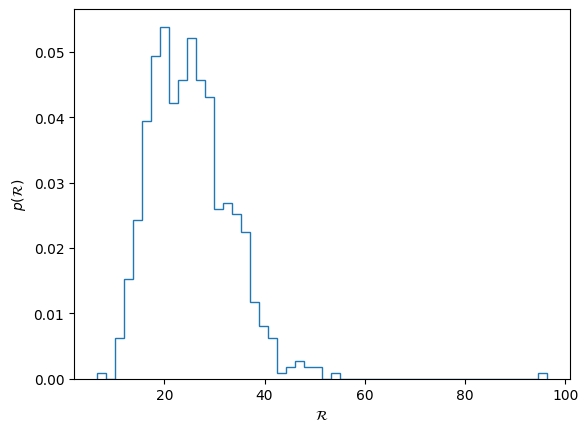

In [ ]:
result_iso = bb.result.read_in_result('Full_tests/O3_ISO_test_result.pkl')

rates = list()
for ii in range(len(result_iso.posterior)):
    likelihood.parameters.update(dict(result_iso.posterior.iloc[ii]))
    rates.append(float(likelihood.generate_rate_posterior_sample()))
result_iso.posterior["rate"] = rates

plt.hist(rates, bins=50, histtype="step", density=True)
plt.xlabel("${\\cal R}$")
plt.ylabel("$p({\\cal R})$")
plt.show()
plt.close()